In [77]:
import pandas as pd
import numpy as np
import os
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import folium
from folium.plugins import HeatMap

os.chdir('C:/Users/39329/OneDrive - ISEG/000 Dissertation/Used Car/Used-Car')

In [78]:
df_original = pd.read_csv("Dataset/vehicles.csv")

In [79]:
df = df_original.copy()

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [81]:
df.nunique(axis=0)

id              426880
url             426880
region             404
region_url         413
price            15655
year               114
manufacturer        42
model            29667
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118264
drive                3
size                 4
type                13
paint_color         12
image_url       241899
description     360911
county               0
state               51
lat              53181
long             53772
posting_date    381536
dtype: int64

- 'url', 'id', 'posting_date', 'image_url' and 'paint_color' have no effect on target variable.
- 'region', 'region_url', 'county', 'state' will be removed as location is already available through lat and long.
- relevant information contained in 'description' and 'size' columns is duplicated since it's already availabe in other features.
- 'model' is a categorical variable with a large number of unique variables and therefore can't be in the model



In [82]:
#Removing non-useful columns
drop_columns = ['url','region','region_url','image_url','county','posting_date','description','state','id','size','paint_color']
df.drop(columns = drop_columns,inplace=True)

## Removing Duplicates

In [83]:
df[df.duplicated('VIN')]['VIN']

1                       NaN
2                       NaN
3                       NaN
4                       NaN
5                       NaN
                ...        
426875    1N4AA6AV6KC367801
426876    7JR102FKXLG042696
426877    1GYFZFR46LF088296
426878    58ABK1GG4JU103853
426879    WBA4J1C58KBM14708
Name: VIN, Length: 308615, dtype: object

In [84]:
df[df['VIN']== '1N4AA6AV6KC367801'][['year','lat','long']]

,year,lat,long
60481,2019.0,33.78650,-84.44540
66450,2019.0,33.78650,-84.44540
72473,2019.0,40.02104,-105.26465
75372,2019.0,38.82108,-104.82311
426875,2019.0,33.78650,-84.44540


*The same car has 5 different listings varying only by location.*

In [85]:
#Removing rows based on VIN number
df.drop_duplicates(subset='VIN', inplace=True, keep ='first')
df.drop(columns='VIN',inplace=True)

## EDA

### Location

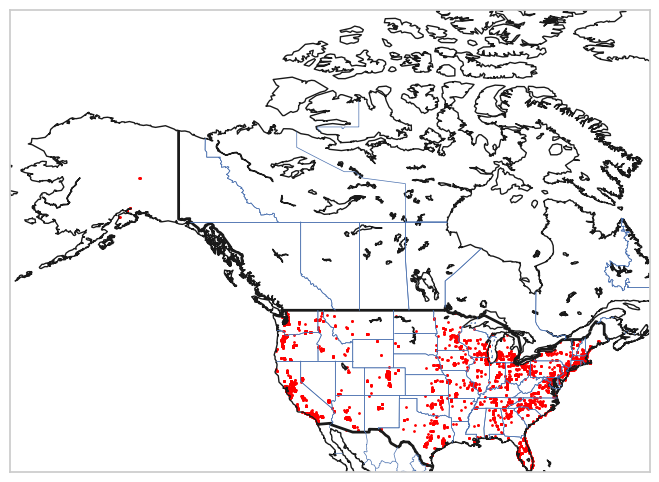

In [86]:
#create a sample of 5% of items
df_sample = df.sample(frac = 0.05)

#create my map
plt.figure(figsize=(12,6))
m = Basemap(projection='mill',
            llcrnrlat = 25,
            llcrnrlon = -170,
            urcrnrlat = 80,
            urcrnrlon = -60,
            resolution='l')
m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates(color='b')

#plot my points
lat = df_sample['lat'].tolist()
lon = df_sample['long'].tolist()
m.scatter(lon, lat, latlon = True, s = 1, c = 'red', marker = 'o', alpha = 1)

plt.show()

*Most cars are in East U.S..* 

Does location have an effect on price keeping car model and year constant?

In [87]:
#Identifying most common car model
df['model'].value_counts()[:1]

f-150    2651
Name: model, dtype: int64

In [88]:
#Identfying most common year
df[df['model']=='f-150']['year'].value_counts().head(1)

2018.0    395
Name: year, dtype: int64

In [89]:
df1 = df[(df['model']=='f-150') & (df['year']==2018)].dropna()

# Create a base map
m = folium.Map(location=[df1['lat'].mean(), df1['long'].mean()], zoom_start=4)

# Add the heatmap
heat_data = [[row['lat'], row['long'], row['price']] for index, row in df1.iterrows()]
HeatMap(heat_data).add_to(m)

display(m)

del(df1)

*Prices are higher near big cities, lat and long will be kept as a feature of our model.*

Now that only columns that have an effect on target variable are remaining, let's remove those rows with N/A values

In [90]:
df.dropna(inplace=True)

### Price

In [91]:
df.price.describe()

count     34450.000000
mean      14835.366618
std       12687.029408
min           0.000000
25%        6499.000000
50%       11000.000000
75%       19900.000000
max      155000.000000
Name: price, dtype: float64

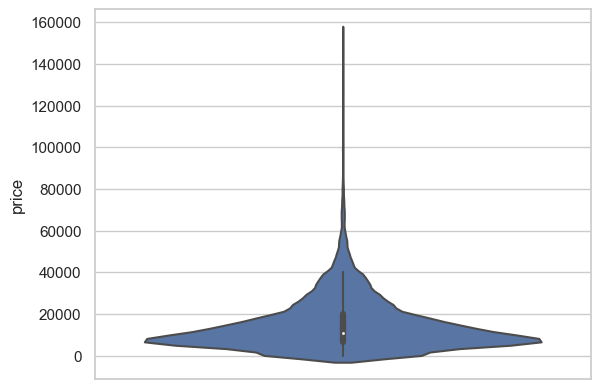

In [92]:
sns.violinplot(y='price', data=df);

To improve Model Accuracy entries with price under ＄100 and above ＄60k will be removed.

In [93]:
df.drop(df[(df['price']<=100) | (df['price']>=6000)].index,inplace=True)

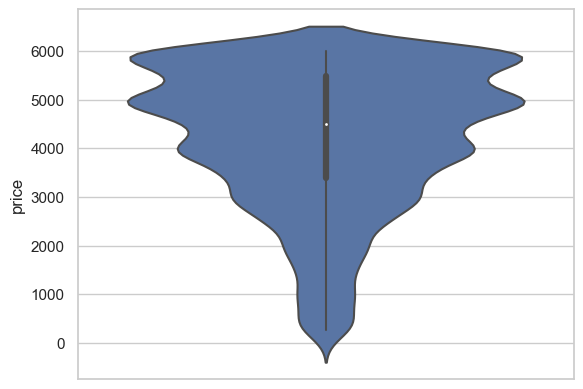

In [94]:
sns.violinplot(y='price', data=df);

### Title Status

In [95]:
df['title_status'].value_counts()

clean         5698
rebuilt        141
salvage         89
lien            17
missing         12
parts only       4
Name: title_status, dtype: int64

To prevent Model Bias and Overfitting entries with 'title_status' not equal to 'clean' will be removed.

In [96]:
df = df[df['title_status'] == 'clean']
df.drop('title_status', axis=1, inplace=True)

### Year

In [97]:
df['year'].describe()

count    5698.000000
mean     2005.524746
std         6.163403
min      1905.000000
25%      2003.000000
50%      2006.000000
75%      2009.000000
max      2022.000000
Name: year, dtype: float64

<Axes: xlabel='year', ylabel='Count'>

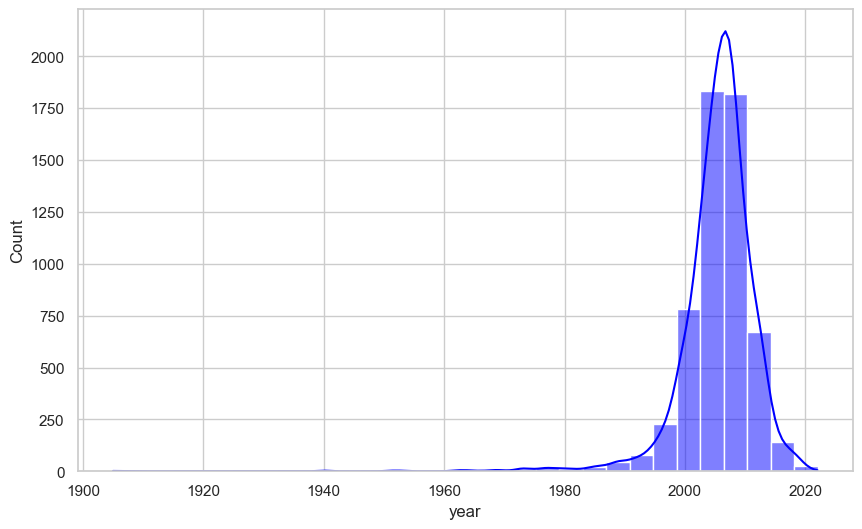

In [98]:
sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))  
sns.histplot(df['year'], kde=True, bins=30, color='blue')

To improve Model Accuracy only entries with 'year' from 1991 to 2020 (range of 30 years) will be kept.

In [99]:
df = df[(df['year'] >= 1990) & (df['year']<2021)]

<Axes: xlabel='year', ylabel='Count'>

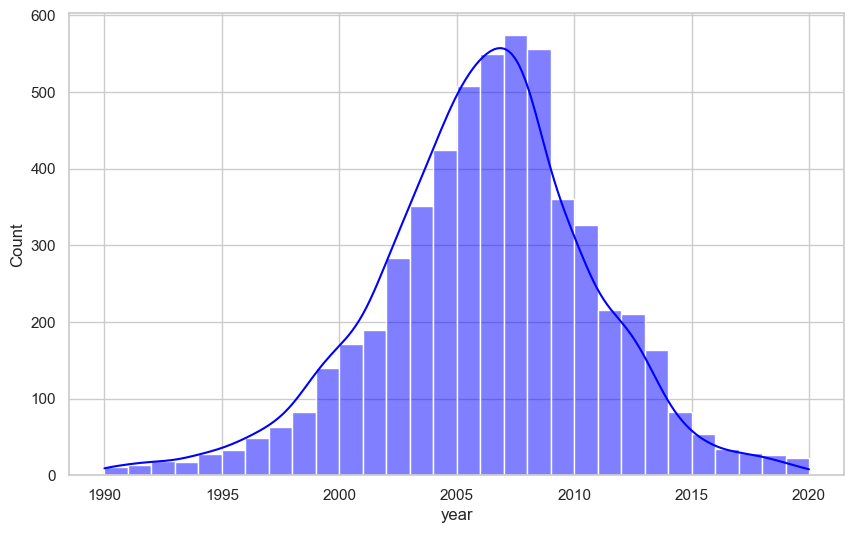

In [100]:
sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))  
sns.histplot(df['year'], kde=True, bins=30, color='blue')

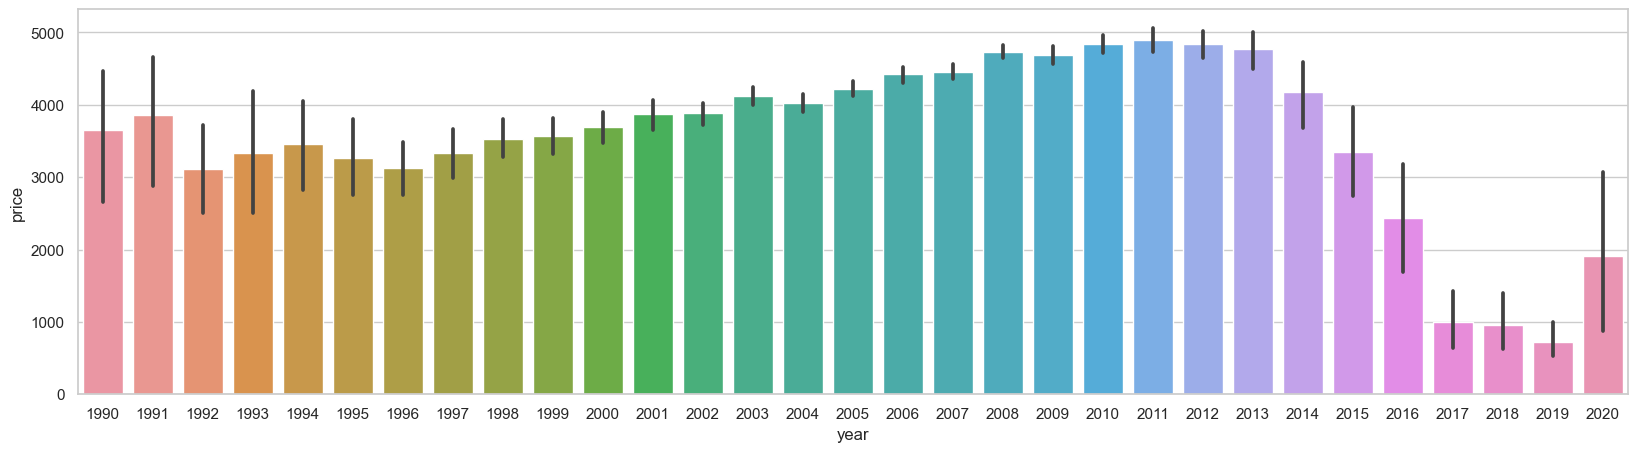

In [101]:
plt.figure(figsize=(20,5))
sns.barplot(data= df,x="year", y= "price")

# Format x-axis tick labels as integers
ax = plt.gca()  # Get the current Axes instance
labels = [int(float(label.get_text())) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels)

plt.show()

*Huge drop in used car prices for cars built after 2013*

### Manufacturers

In [102]:
manufacturer_counts = df['manufacturer'].value_counts()
manufacturer_counts

ford             724
chevrolet        666
toyota           628
honda            574
nissan           321
hyundai          216
dodge            197
jeep             189
chrysler         188
subaru           168
volkswagen       159
mazda            139
kia              132
buick            126
pontiac          122
bmw              109
gmc              105
mercedes-benz     93
volvo             90
saturn            82
mercury           68
lexus             66
cadillac          58
mitsubishi        58
lincoln           56
acura             52
ram               41
infiniti          37
mini              36
audi              35
fiat              21
jaguar            20
rover              7
alfa-romeo         2
porsche            2
land rover         1
Name: manufacturer, dtype: int64

To improve Model Accuracy only manufacturers with more than 100 entries are kept.

In [103]:
df = df[df['manufacturer'].isin(manufacturer_counts[manufacturer_counts > 100].index)]

### Condition

In [104]:
condition_count = df['condition'].value_counts()
condition_count

excellent    2142
good         2064
fair          295
like new      247
salvage         9
new             6
Name: condition, dtype: int64

To improve Model Accuracy only entries with 'condition' equal to **excellent, good, fair** and **like new** are kept.

In [105]:
df = df[df['condition'].isin(condition_count[condition_count > 100].index)]

### Trasmission

In [106]:
df['transmission'].value_counts()

automatic    4331
manual        394
other          23
Name: transmission, dtype: int64

To improve Model Accuracy entries with 'transmission' equal to **other** are removed

In [107]:
df = df[df['transmission'] != 'other']

### Fuel

In [108]:
df['fuel'].value_counts()

gas         4587
hybrid        83
diesel        31
other         17
electric       7
Name: fuel, dtype: int64

To improve Model Accuracy only entries with 'fuel' equal to **gas** are kept

In [109]:
df = df[df['fuel']=='gas'] 
df.drop(columns = 'fuel',inplace = True)

### Type

In [110]:
type_count = df['type'].value_counts()
type_count

sedan          2012
SUV            1140
hatchback       279
mini-van        265
coupe           207
wagon           180
truck           176
pickup          121
van             107
convertible      78
other            17
bus               5
Name: type, dtype: int64

To improve Model Accuracy only entries whose type appears more than 100 times is kept.

In [111]:
df = df[df['type'].isin(type_count[type_count > 100].index)]

### Converting Categorical Variables

Because we will use LGBMRegressor we will integer-encode all categorical variables

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4487 entries, 215 to 426737
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         4487 non-null   int64  
 1   year          4487 non-null   float64
 2   manufacturer  4487 non-null   object 
 3   model         4487 non-null   object 
 4   condition     4487 non-null   object 
 5   cylinders     4487 non-null   object 
 6   odometer      4487 non-null   float64
 7   transmission  4487 non-null   object 
 8   drive         4487 non-null   object 
 9   type          4487 non-null   object 
 10  lat           4487 non-null   float64
 11  long          4487 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 455.7+ KB


In [113]:
categorical_cols = ['manufacturer', 'model', 'condition', 'cylinders', 'transmission', 'drive', 'type']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [114]:
df.to_csv("Dataset/vehicles_clean.csv",index=False)